<실습 데이터셋>
 - 공공데이터 포털(www.data.go.kr)
 - 국가통계포털(https://kosis.kr/index/index.do)
 - 케글(https://www.kaggle.com/)
 - AI‑Hub(https://www.aihub.or.kr/)

9. 서울 NO₂ (2008–2023)
    - 내용: 서울시 NO₂ 농도 데이터
    - 장점: 긴 기간(15년) 분석에 적합
    - URL: Kaggle “NO2 in Seoul, Korea, from 2008 to 2023”

### 사용할 라이브러리

In [1]:
### 날짜 관련
import datetime

### 데이터 조작
import pandas as pd

### 시각화
import matplotlib.pyplot as plt

### 한글처리
plt.rc("font", family = "Malgun Gothic")

### 마이너스기호 처리
plt.rcParams["axes.unicode_minus"] = False

### 시계열 분석 모델
from statsmodels.tsa.arima.model import ARIMA

In [2]:
### 데이터 읽기
data = pd.read_csv("./data/no2_in_seoul.csv")
data

,date,no2(ppm)
0,2018-01-01,0.029
1,2018-01-02,0.035
2,2018-01-03,0.024
3,2018-01-04,0.039
4,2018-01-05,0.050
...,...,...
5380,2017-12-27,0.013
5381,2017-12-28,0.019
5382,2017-12-29,0.015
5383,2017-12-30,0.029


In [3]:
### 데이터 정보 확인
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5385 entries, 0 to 5384
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   date      5385 non-null   object 
 1   no2(ppm)  5385 non-null   float64
dtypes: float64(1), object(1)
memory usage: 84.3+ KB


,date,no2(ppm)
0,2018-01-01,0.029
1,2018-01-02,0.035
2,2018-01-03,0.024
3,2018-01-04,0.039
4,2018-01-05,0.050


In [4]:
### date 컬럼을 날짜 타입으로 변경
data['date'] = pd.to_datetime(data['date'])

### date 컬럼을 인덱스로 변경
data.set_index('date', inplace=True)

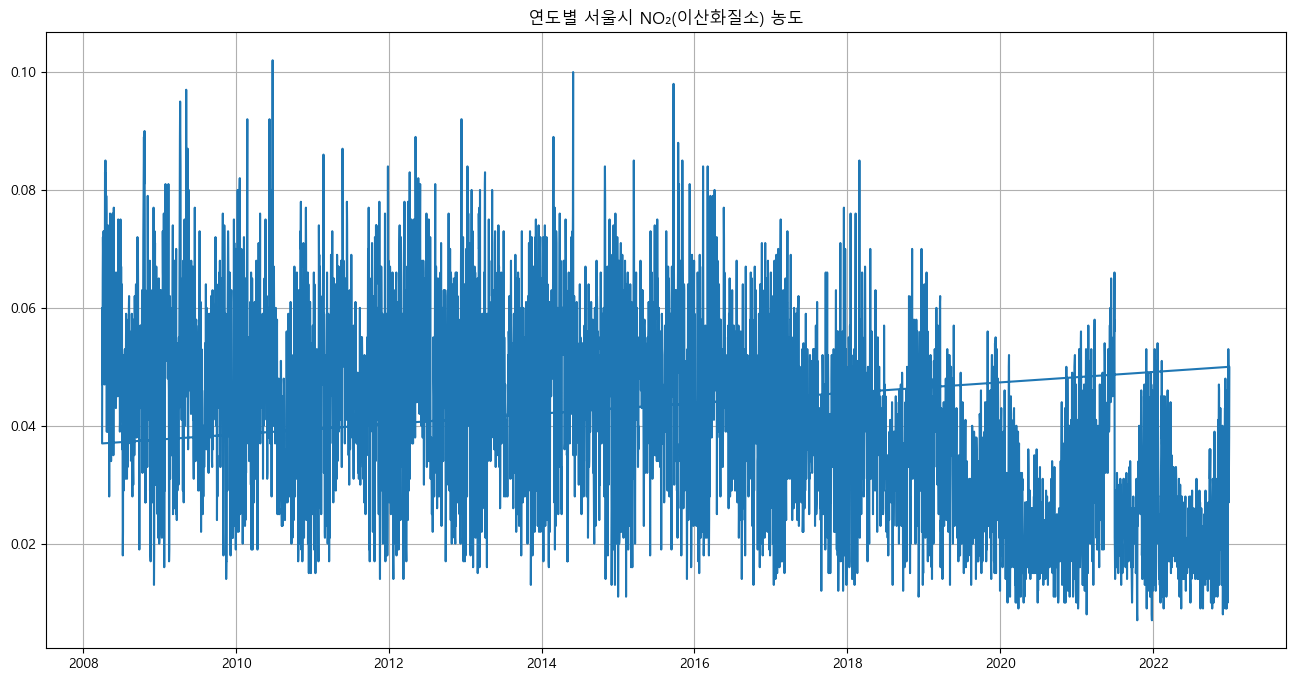

In [5]:
### 데이터 시각화
plt.figure(figsize=(16,8))
plt.title("연도별 서울시 NO₂(이산화질소) 농도")
plt.plot(data)
plt.grid()

plt.show()

### 시계열 데이터 정상성 확인하기 -> ADF 테스트

In [6]:
### ADF 라이브러리 정의
from statsmodels.tsa.stattools import adfuller

In [7]:
### 데이터 확인하기
data.values

array([[0.029],
       [0.035],
       [0.024],
       ...,
       [0.015],
       [0.029],
       [0.047]])

In [8]:
### ADF 테스트에 사용할 데이터 : no2(ppm) 데이터, 인덱스는 Date 날짜
# - 데이터만 추출하여 사용 : 1차원 데이터
result = adfuller(data.values)
result

(-4.366124718227502,
 0.0003406009283504718,
 33,
 5351,
 {'1%': -3.431572657401962,
  '5%': -2.8620802901611566,
  '10%': -2.567057595766886},
 -31901.491163989653)

In [9]:
### 테스트 결과
(-4.366124718227502,                 # ADF 검정 통계량
 0.0003406009283504718,              # p-value
 33,                                 # 사용된 래그 개수
 5351,                               # 유효 관측값 수
 {'1%': -3.431572657401962,          # 임계값들
  '5%': -2.8620802901611566,
  '10%': -2.567057595766886},
 -31901.491163989653                 # 최적 AIC
)

# 검정 통계량 = -4.366
# 1% 임계값 = -3.43
#  → 검정 통계량이 1% 임계값보다도 작음 → 정상성 있음으로 결론지을 수 있음

(-4.366124718227502,
 0.0003406009283504718,
 33,
 5351,
 {'1%': -3.431572657401962,
  '5%': -2.8620802901611566,
  '10%': -2.567057595766886},
 -31901.491163989653)

### ARIMA 모델 훈련을 위한 하이퍼파라메터 찾기

In [10]:
### ndiffs(Number of Differences) 함수 사용
# - 차분 차수를 "결정"하는 함수
# - pmdarima 라이브러리 사용

import pmdarima as pm
from pmdarima.arima import ndiffs

In [11]:
### 사용중인 데이터
data

,no2(ppm)
date,
2018-01-01,0.029
2018-01-02,0.035
2018-01-03,0.024
2018-01-04,0.039
2018-01-05,0.050
...,...
2017-12-27,0.013
2017-12-28,0.019
2017-12-29,0.015


In [12]:
### 차분 차수 결정하기
# - 시계열 데이터를 정상성
#   -> 몇번의 차분(differencing)이 필요한지를 결정하는 함수

# - data : 시간 단위 수정종가 데이터
# - alpha : 차분 횟수를 결정하는데 사용할 p-value(유의수준) 기준값
# - test : 차분 횟수를 결정하는데 사용할 테스트 방법 지정(일반적으로 adf 사용)
# - max_d : 최대 차분 횟수를 제한(최대 차분 횟수 내에서 가장 적절한 차수 결정)

### 결정된 차분 차수의 "d값"은 -> auto_arima 수행 시 사용됨
n_diffs = ndiffs(data, alpha=0.05, test="adf", max_d=6)
print(f"결정된 차분(d)의 차수 : {n_diffs}d")

결정된 차분(d)의 차수 : 0d


In [13]:
### 해석
# 기존 데이터를 확인 했을 때 ADF 테스트의 값이 정상성을 만족하기 때문에 차분차수 결정 함수를 이용하여 확인 시에도 0차분이 확인됨

### 훈련 및 테스트 데이터로 분리하여 훈련 및 테스트 진행

In [14]:
### 훈련 : 테스트 = 9:1로 분류하여 auto_arima 함수로 최적의 모델 찾기
# - 분류 방법 : 연속형 시계열 데이터는 기존의 train_test_split 함수 사용 못함(랜덤으로 섞기 때문)
#             : 시계열 데이터의 앞쪽 90% 와 뒤쪽 10%의 비율로 분리하여 사용
# 훈련 데이터 변수명 : train_data
# 테스트 데이터 변수명 : test_data
train_data = data[ : int(len(data)*0.9)]
test_data = data[int(len(data)*0.9) : ]

train_data.shape, test_data.shape

((4846, 1), (539, 1))

### 계절성 미적용

In [15]:
### 1. 훈련 데이터로 auto_arima 훈련 시키기(계절성 미적용)
# - 변수명 : best_model_sFalse

best_model_sFalse = pm.auto_arima(
    y = train_data,
    # 차분의 차수 : 지정하지 않으면 기본값 None (훈련 시간이 매우 길어짐)
    #             : 일반적으로 ndiffs() 함수를 통해 찾은 값을 사용하면 됨
    d = 1,
    
    # p(AR)를 찾기 위한 범위를 지정(start_p 에서 max_p까지의 값 범위 내 찾기)
    # - start_p의 기본값은 2, max_p의 기본값은 5
    start_p = 0, max_p = 5,
    
    # q(MA)를 찾기 위한 범위를 지정(start_q 에서 max_q까지의 값 범위 내 찾기)
    # - start_q의 기본값은 2, max_q의 기본값은 5
    start_q = 0, max_q = 5,
    
    # m : 계절적(seasonal) 특성에 따라 사용되는 값(기본값은 1)
    # - m=1 : 계절적 특성이 없을 때(seasonal=False) 1을 사용함
    
    # <계절적 특성이 있을 때>
    # - m=3 : 데이터가 월 단위로 나와있고 매 3개월마다 반복되는 계절성이 있는 경우 사용
    # - m=4 : 데이터가 분기 단위로 나와있고, 분기별 데이터에서 연간(4분기) 계절성이 있는 경우 사용
    # - m=12 : 데이터가 월 단위로 나와있고 월별 데이터에서 연간(12개월) 계절성이 있는 경우 사용
    # - m=52 : 데이터가 주 단위로 나와있고 주별 데이터에서 연간(52주) 계절성이 있는 경우 사용
    m = 1,
    
    # seasonal : 계절성 특성 여부 설정(기본값은 False)
    # - seasonal=False : 계절성 특성을 적용 안함(m=1로 설정하게 됨)
    # - seasonal=True : 계절성 특성을 적용한 경우(m의 값은 데이터 성격에 맞게 정의)
    # 계절성을 적용할지 말지는 auto_arima 모델에 False인 경우와 True인 경우를 각각 수행
    #   -> best_model의 AIC의 값이 작은 best_model을 선택하면 됨 
    seasonal = False,
    
    # stepwise : 최적의 모수를 찾기 위한 알고리즘을 사용할지 여부(기본값은 True)
    # - stepwise=True : 단계적으로 최적의 ARIMA 모델을 찾는 방법을 수행
    #                 : (p, d, q)에 대한 값들의 조합을 하나씩 바꿔가면서 AIC(or BIC)가 가장 낮은 시점의 모델을 탐색
    #                 : AIC가 낮아지면 그 방향으로 계속 움직이면서 성능 개선
    #                 : 더 이상 개선되지 않으면 훈련 종료
    #                 : (예시) 계단을 오르듯이 한 발씩 오르면서 최적값을 찾는다는 의미
    # - stepwise=False : 가능한 조합의 모든 (p, d, q)를 모두 탐색함
    #                  : 좋아지는 방향을 찾기 보다는 (p, d, q)의 모든 조합을 각각 수행하여 결정
    #                  : (예시) p=0~5, q=0~5 일때, 총 36개 이상의 조합을 모두 각각 훈련하는 방법
    #                  : 정확도는 True보다 다소 높을 수 있으나 매우 느리고 계산량이 많아짐
    stepwise = True,
    
    # 자동 모형 선택 과정의 출력을 보여줄지 여부 설정(기본값은 False)
    # - auto_arima가 어떤 (p, d, q) 조합을 시도하고 있는지 콘솔에 하나하나 출력해줌 
    trace = True
)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-27254.545, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-27445.635, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-28040.626, Time=1.35 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-27256.545, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-28657.279, Time=1.35 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-28888.227, Time=3.16 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-27954.001, Time=0.57 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-28739.537, Time=5.25 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-28855.095, Time=1.51 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-28835.460, Time=2.32 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-28110.169, Time=0.70 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-28792.547, Time=3.60 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-28890.549, Time=1.35 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-28792.110, Time=0.64 sec
 ARIM

### 계절성 적용

In [16]:
### 2. 훈련 데이터로 auto_arima 훈련 시키기(계절성 적용)
# - 변수명 : best_model_sTrue
best_model_sTrue = pm.auto_arima(
    y = train_data,
    # 차분의 차수 : 지정하지 않으면 기본값 None (훈련 시간이 매우 길어짐)
    #             : 일반적으로 ndiffs() 함수를 통해 찾은 값을 사용하면 됨
    d = 1,
    
    # p(AR)를 찾기 위한 범위를 지정(start_p 에서 max_p까지의 값 범위 내 찾기)
    # - start_p의 기본값은 2, max_p의 기본값은 5
    start_p = 0, max_p = 5,
    
    # q(MA)를 찾기 위한 범위를 지정(start_q 에서 max_q까지의 값 범위 내 찾기)
    # - start_q의 기본값은 2, max_q의 기본값은 5
    start_q = 0, max_q = 5,
    
    # m : 계절적(seasonal) 특성에 따라 사용되는 값(기본값은 1)
    # - m=1 : 계절적 특성이 없을 때(seasonal=False) 1을 사용함
    
    # <계절적 특성이 있을 때>
    # - m=3 : 데이터가 월 단위로 나와있고 매 3개월마다 반복되는 계절성이 있는 경우 사용
    # - m=4 : 데이터가 분기 단위로 나와있고, 분기별 데이터에서 연간(4분기) 계절성이 있는 경우 사용
    # - m=12 : 데이터가 월 단위로 나와있고 월별 데이터에서 연간(12개월) 계절성이 있는 경우 사용
    # - m=52 : 데이터가 주 단위로 나와있고 주별 데이터에서 연간(52주) 계절성이 있는 경우 사용
    m = 6,
    
    # seasonal : 계절성 특성 여부 설정(기본값은 False)
    # - seasonal=False : 계절성 특성을 적용 안함(m=1로 설정하게 됨)
    # - seasonal=True : 계절성 특성을 적용한 경우(m의 값은 데이터 성격에 맞게 정의)
    # 계절성을 적용할지 말지는 auto_arima 모델에 False인 경우와 True인 경우를 각각 수행
    #   -> best_model의 AIC의 값이 작은 best_model을 선택하면 됨 
    seasonal = True,
    
    # stepwise : 최적의 모수를 찾기 위한 알고리즘을 사용할지 여부(기본값은 True)
    # - stepwise=True : 단계적으로 최적의 ARIMA 모델을 찾는 방법을 수행
    #                 : (p, d, q)에 대한 값들의 조합을 하나씩 바꿔가면서 AIC(or BIC)가 가장 낮은 시점의 모델을 탐색
    #                 : AIC가 낮아지면 그 방향으로 계속 움직이면서 성능 개선
    #                 : 더 이상 개선되지 않으면 훈련 종료
    #                 : (예시) 계단을 오르듯이 한 발씩 오르면서 최적값을 찾는다는 의미
    # - stepwise=False : 가능한 조합의 모든 (p, d, q)를 모두 탐색함
    #                  : 좋아지는 방향을 찾기 보다는 (p, d, q)의 모든 조합을 각각 수행하여 결정
    #                  : (예시) p=0~5, q=0~5 일때, 총 36개 이상의 조합을 모두 각각 훈련하는 방법
    #                  : 정확도는 True보다 다소 높을 수 있으나 매우 느리고 계산량이 많아짐
    stepwise = True,
    
    # 자동 모형 선택 과정의 출력을 보여줄지 여부 설정(기본값은 False)
    # - auto_arima가 어떤 (p, d, q) 조합을 시도하고 있는지 콘솔에 하나하나 출력해줌 
    trace = True
)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[6] intercept   : AIC=-27255.328, Time=1.17 sec
 ARIMA(0,1,0)(0,0,0)[6] intercept   : AIC=-27254.545, Time=0.20 sec
 ARIMA(1,1,0)(1,0,0)[6] intercept   : AIC=-27447.352, Time=0.83 sec
 ARIMA(0,1,1)(0,0,1)[6] intercept   : AIC=-28068.184, Time=3.90 sec
 ARIMA(0,1,0)(0,0,0)[6]             : AIC=-27256.545, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[6] intercept   : AIC=-28040.626, Time=1.31 sec
 ARIMA(0,1,1)(1,0,1)[6] intercept   : AIC=-28062.895, Time=2.96 sec
 ARIMA(0,1,1)(0,0,2)[6] intercept   : AIC=-28061.131, Time=5.37 sec
 ARIMA(0,1,1)(1,0,0)[6] intercept   : AIC=-28065.577, Time=2.16 sec
 ARIMA(0,1,1)(1,0,2)[6] intercept   : AIC=-28071.465, Time=6.01 sec
 ARIMA(0,1,1)(2,0,2)[6] intercept   : AIC=-28064.110, Time=4.62 sec
 ARIMA(0,1,1)(2,0,1)[6] intercept   : AIC=-28069.796, Time=5.41 sec
 ARIMA(0,1,0)(1,0,2)[6] intercept   : AIC=-27251.589, Time=0.69 sec
 ARIMA(1,1,1)(1,0,2)[6] intercept   : AIC=-28646.762, Time=4.11 sec
 ARIM

In [17]:
### sFalse = ARIMA(1,1,2)(0,0,0)[0]             : AIC=-28902.727, Time=1.00 sec
### sTrue  = ARIMA(1,1,2)(0,0,1)[6]             : AIC=-28905.611, Time=1.93 sec

### 해석
# - 계절성을 적용하지 않은 모델과 적용한 최적의 모델의 결과값의 차이가 거의 없었음
# - 차이가 없긴 하나 AIC 값이 더 적은 계절성 미적용 모델을 선택함

### 훈련모델을 이용한 계절성 여부에 따른 최적의 모델 성능 검정(평가)하기

In [18]:
### 계절성 미적용 : 검정(평가) 함수 : summary()
best_model_sFalse.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 4846
Model:               SARIMAX(1, 1, 2)   Log Likelihood               14455.364
Date:                Tue, 17 Jun 2025   AIC                         -28902.727
Time:                        17:26:47   BIC                         -28876.784
Sample:                             0   HQIC                        -28893.620
                               - 4846                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0945      0.030      3.188      0.001       0.036       0.153
ma.L1         -0.5884      0.028    -21.001      0.000      -0.643      -0.533
ma.L2         -0.3559      0.026    -13.885      0.000      -0.406      -0.306
sigma2         0.0001   2.98e-06     50.302      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                15.42
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               2.10   Skew:                            -0.11
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [19]:
### 계절성 미적용 : 검정(평가) 함수 : summary()
best_model_sTrue.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 4846
Model:             SARIMAX(1, 1, 2)x(0, 0, [1], 6)   Log Likelihood               14457.805
Date:                             Tue, 17 Jun 2025   AIC                         -28905.611
Time:                                     17:26:47   BIC                         -28873.182
Sample:                                          0   HQIC                        -28894.227
                                            - 4846                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0887      0.030      2.956      0.003       0.030       0.148
ma.L1         -0.5815      0.028    -20.538      0.000      -0.637      -0.526
ma.L2         -0.3585      0.026    -13.996      0.000      -0.409      -0.308
ma.S.L6       -0.0331      0.014     -2.441      0.015      -0.060      -0.007
sigma2         0.0001   2.97e-06     50.353      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                16.27
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.10   Skew:                            -0.11
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

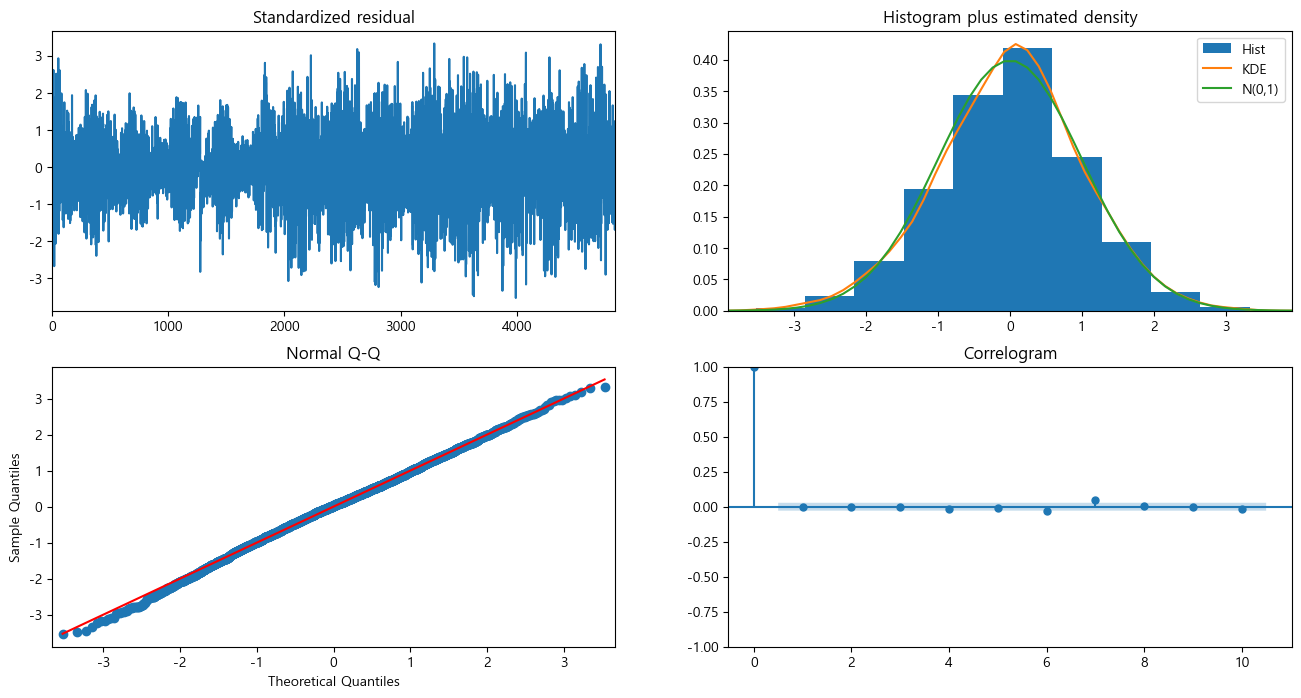

In [20]:
### 계절성 미적용 : 검정(평가) 함수 : plot_diagnostics()
best_model_sFalse.plot_diagnostics(figsize=(16, 8))
plt.show()

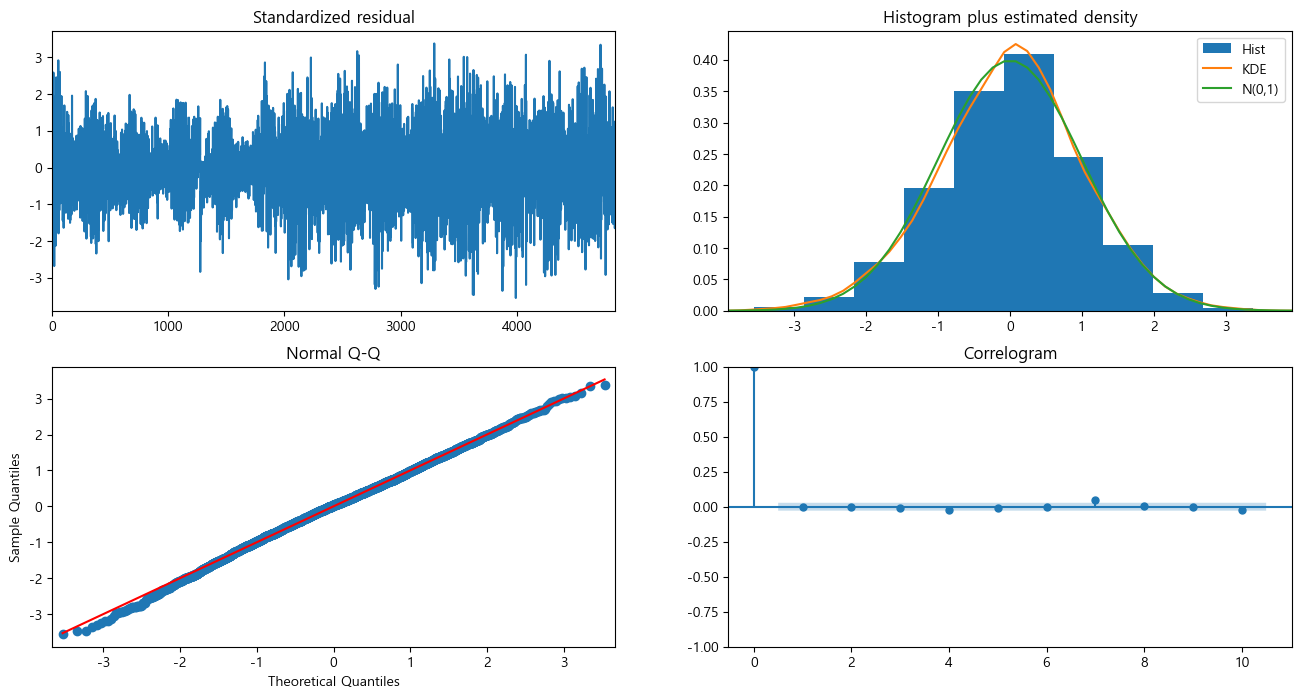

In [21]:
### 계절성 미적용 : 검정(평가) 함수 : plot_diagnostics()
best_model_sTrue.plot_diagnostics(figsize=(16, 8))
plt.show()

### 최종 훈련 모델 선정하기

- 훈련 모델 선정 결과
    - 계절성을 적용한 모델과 미적용한 모델의 성능 평가 결과
        - AIC, BIC, HQIC 지표 모두 계절성을 미적용한 경우에 가장 좋은 결과를 얻었음
    - 따라서 계절성을 미적용한 최적의 모델을 선정하여 예측에 활용하는 것이 타당함
    - 즉, 계절성 미적용 모델이 적용 모델보다 자기상관 및 정규분포성에서 다소 좋은 모델로 여겨짐

### 테스트 데이터로 예측하기

In [22]:
### 예측 함수 생성하기

import numpy as np

# - model : best model
# - n : 예측하려는 향후 기간(디폴트로 1을 지정, 1일을 의미함)
def forecast_n_step(model, n=1) :
    ### 예측하기
    # - n_periods : 예측기간 (일단위)
    # - return_conf_int : 신뢰구간(상한가/하한가) 반환여부
    # - fc : 예측 결과
    # - conf_int : 예측된 신뢰구간값(상한가/하한가)
    fc, conf_int = model.predict(n_periods=n, return_conf_int=True)
    # print(fc, conf_int)
    return (
        fc.tolist()[0:n],
        np.asarray(conf_int).tolist()[0:n]
    )


In [23]:
### 예측을 위한 실행 함수 생성하기 (데이터 여부에 따른 반복 수행)
# - 최종 예측 결과를 반환(return)할 때 시리즈타입으로 반환하기 위해 판다스 적용
import pandas as pd

def forecast(len, model, index, data=None) :
    ### 예측 결과값을 담을 리스트 변수 정의
    # - 예측 결과
    y_pred = []
    # - 상한가
    pred_upper = []
    # - 하한가
    pred_lower = []
   
    ### 데이터(data) 값이 있는 경우
    # - 훈련모델을 이용해서 테스트 데이터로 예측하고자 할 때
    # - 테스트 데이터의 실제값과 예측값을 시각화하여 비교하고자 할 때
    if data is not None :
        ### 각 시간단위 데이터 별로 반복 수행하기
        for new_data in data :
            ### 각 데이터로 예측하기 : 예측 함수 정의 및 호출하여 사용
            # - fc : 예측결과(y_pred에 넣을 값)
            # - conf : 신뢰구간 (상한가 및 하한가 값)
            fc, conf = forecast_n_step(model)
            ### 반환값의 형태
            #   : [146.4129300335647] [[144.6020755382728, 148.22378452885658]]
            # print(fc, conf)
           
            ### 예측 결과를 리스트 변수에 담기
            # - 예측결과
            y_pred.append(fc[0])
           
            # - 상한가
            pred_upper.append(conf[0][1])
           
            # - 하한가
            pred_lower.append(conf[0][0])
           
            ### 각 데이터별로 예측 후에 model을 해당 데이터로 업데이트 합니다.
            # - 시계열에서는 데이터별로 model을 갱신하면서 반복 수행해야 합니다.
            model.update(new_data)          
           
   
    ### 데이터(data) 값이 없는 경우
    # - 향후를 예측할 때 사용(현재 일 이후 향후 데이터는 없는 상태가 됨)
    # - 이때 아래 else 영역을 이용하게 됨
    else :
        ### 받아온 매개변수 len의 갯수를 이용해서 반복 수행하기
        for i in range(len) :
            ### 각 데이터로 예측하기 : 예측 함수 정의 및 호출하여 사용
            # - fc : 예측결과(y_pred에 넣을 값)
            # - conf : 신뢰구간 (상한가 및 하한가 값)
            fc, conf = forecast_n_step(model)
            ### 반환값의 형태
            #   : [146.4129300335647] [[144.6020755382728, 148.22378452885658]]
            # print(fc, conf)
           
            ### 예측 결과를 리스트 변수에 담기
            # - 예측결과
            y_pred.append(fc[0])
           
            # - 상한가
            pred_upper.append(conf[0][1])
           
            # - 하한가
            pred_lower.append(conf[0][0])
           
            ### 각 데이터별로 예측 후에 model을 해당 데이터로 업데이트 합니다.
            # - 시계열에서는 데이터별로 model을 갱신하면서 반복 수행해야 합니다.
            model.update(fc[0])

    ### 반환하기
    # - 예측결과는 -> 시리즈 타입으로 반환하기
    # - 튜플로 (예측결과[시리즈타입], 상한가, 하한가)
    return pd.Series(y_pred, index), pred_upper, pred_lower

In [24]:
### 함수 호출 영역
# - fc : 예측결과
# - upper : 상한가
# - lower : 하한가

# - 실제 사용하는 값 : best_model_sTrue, index, data
# - len값은 별도로 사용(data가 없을 때 사용 예정)
fc, upper, lower = forecast(len(test_data), best_model_sTrue,
                             test_data.index, data=test_data)

fc, upper, lower

c:\Users\Administrator\anaconda3\envs\pk_dl_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Administrator\anaconda3\envs\pk_dl_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


ValueError: could not convert string to float: 'no2(ppm)'

### 시각화 하기

In [ ]:
### 실제 테스트 데이터와 예측 데이터 비교를 위한 시각화
# - 상한가와 하한가를 포함하여 시각화
# - 상한가와 하한가도 시각화를 위해 시리즈 타입으로 변환
# - 상한가 및 하한가의 시리즈 index는 test_data의 index값 사용

# 하한가
lower_series = pd.Series(lower, index=test_data.index)

# 상한가
upper_series = pd.Series(upper, index=test_data.index)

print(lower_series.shape, upper_series.shape)
lower_series, upper_series

In [ ]:
### 실제 테스트 데이터와 예측 데이터 추이 비교 시각화
plt.figure(figsize=(20, 6))
plt.title("시계열 분석 결과 시각화")

### 훈련 데이터
# plt.plot(train_data, label="훈련 데이터", c="green")

### 실제 테스트 데이터
plt.plot(test_data, label="실제 테스트 데이터", c="blue")

### 예측 데이터
plt.plot(fc, label="예측결과", c="red")

### 상한가 / 하한가 그리기
# - fill_between() 함수 이용 : 위/아래(상한가/하한가) 영역을 음영으로 표시하여 시각화 하는 함수
# - alpha : 투명도(값이 클수록 짙어짐, 0~1 사이의 값 사용)
plt.fill_between(lower_series.index, lower_series, upper_series, alpha=0.7, label="상한가/하한가", color="gray")

plt.legend()
plt.show()

### 회귀모델 성능평가

In [ ]:
### 시계열 분석은 선형 분석과 동일하기에 회귀모델의 성능 평가지표를 사용할 수 있음

### 평가 라이브러리 정의
# 평균절대오차(MAE)
from sklearn.metrics import mean_absolute_error
# 평균제곱오차(MSE)
from sklearn.metrics import mean_squared_error
# 결정계수(R2-score)
from sklearn.metrics import r2_score


# MAE
mae = mean_absolute_error(test_data, fc)

# MSE
mse = mean_squared_error(test_data, fc)

# R2
r2 = r2_score(test_data, fc)

mae, mse, r2

### 결정력 0.97로 수정종가를 이용하여 예측을 위한 모델로 활용 가능하고 매우 훌륭한 모델로 판단됨